In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten, SimpleRNN, GRU
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
#Loading and preparing the data
test = pd.read_csv('/content/drive/MyDrive/RNN/test.csv')
train = pd.read_csv('/content/drive/MyDrive/RNN/train.csv')

train_set = train.iloc[:,1:2].values
minmaxsc = MinMaxScaler()
train_set_scaled = minmaxsc.fit_transform(train_set)

x_train, y_train = [], []
for i in range(120, len(train_set_scaled)):
    x_train.append(train_set_scaled[i-120:i, 0])
    y_train.append(train_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# LSTM

In [ ]:
results = []

#Hyperparameter tuning
for units in [64, 128]:
    for learning_rate in [0.01, 0.001]:
        for dropout in [0.1, 0.2]:
            print(f"Training with units={units}, learning_rate={learning_rate}, dropout={dropout}")

            #Building the model
            model = Sequential()
            model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
            model.add(Dropout(dropout))
            model.add(LSTM(units=units // 2, return_sequences=False))
            model.add(Dropout(dropout))
            model.add(Dense(units=1, activation='linear'))

            # Compiling the model
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mean_squared_error')

            history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

            #Calculating validation loss
            val_loss = history.history['val_loss'][-1]
            print(f"Validation Loss: {val_loss}")

            results.append({
                'units': units,
                'learning_rate': learning_rate,
                'dropout': dropout,
                'val_loss': val_loss
            })

results_df = pd.DataFrame(results)

#Printing the best hyperparameter combinations
best_config = results_df.sort_values(by='val_loss', ascending=True).iloc[0]
print("Best Hyperparameters:")
print(best_config)

Training with units=64, learning_rate=0.01, dropout=0.1
Epoch 1/30
29/29 [==============================] - 6s 113ms/step - loss: 0.0179 - val_loss: 0.0033
Epoch 2/30
29/29 [==============================] - 3s 88ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 3/30
29/29 [==============================] - 3s 94ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/30
29/29 [==============================] - 2s 79ms/step - loss: 0.0017 - val_loss: 6.9869e-04
Epoch 5/30
29/29 [==============================] - 2s 81ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 6/30
29/29 [==============================] - 2s 81ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/30
29/29 [==============================] - 2s 80ms/step - loss: 0.0017 - val_loss: 6.4426e-04
Epoch 8/30
29/29 [==============================] - 3s 95ms/step - loss: 0.0016 - val_loss: 6.2518e-04
Epoch 9/30
29/29 [==============================] - 2s 80ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/30
29/29 [=====================

In [ ]:
# Building the final model
final_model = Sequential()
final_model.add(LSTM(units=int(best_config['units']), return_sequences=True, input_shape=(x_train.shape[1], 1)))
final_model.add(Dropout(best_config['dropout']))
final_model.add(LSTM(units=int(best_config['units'] // 2), return_sequences=False))
final_model.add(Dropout(best_config['dropout']))
final_model.add(Dense(units=1, activation='linear'))

final_model.compile(optimizer=Adam(learning_rate=best_config['learning_rate']), loss='mean_squared_error')

history = final_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
29/29 [==============================] - 8s 194ms/step - loss: 0.0957 - val_loss: 0.0480
Epoch 2/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 3/100
29/29 [==============================] - 4s 146ms/step - loss: 0.0024 - val_loss: 9.7993e-04
Epoch 4/100
29/29 [==============================] - 5s 159ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 5/100
29/29 [==============================] - 4s 147ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/100
29/29 [==============================] - 4s 155ms/step - loss: 0.0014 - val_loss: 8.1538e-04
Epoch 8/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/100
29/29 [==============================] - 4s 152ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/100
29/29 [==============================] - 5s 156ms/step - loss: 0.0015 

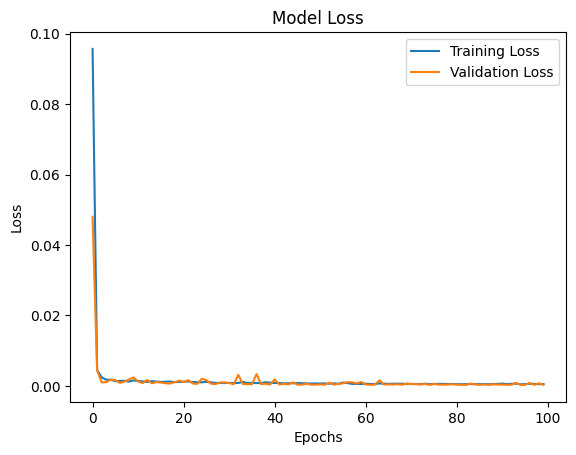

In [ ]:
# Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
#Preparing test data
real_stock_price = test.iloc[:,1:2].values
dataset = pd.concat((train['Open'], test['Open']), axis=0)
inputs = dataset[len(dataset) - len(test) - 120:].values
inputs = inputs.reshape(-1, 1)
inputs = minmaxsc.transform(inputs)

x_test = []
for i in range(120, 140):
    x_test.append(inputs[i-120:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#Predicting on testing data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = minmaxsc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 695ms/step


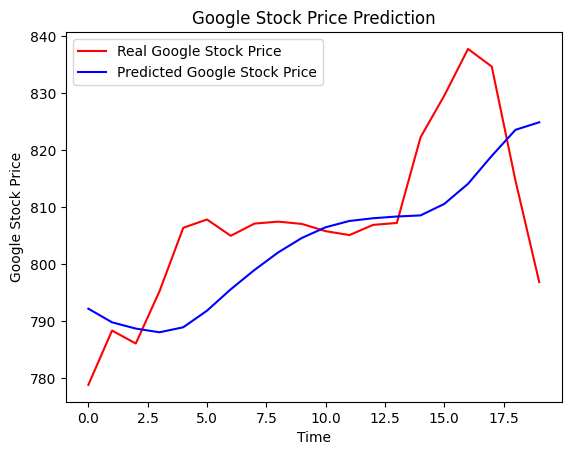

In [ ]:
# Plotting the results
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
#Calculating MSE and RMSE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 161.29346244751088
Root Mean Squared Error (RMSE): 12.70013631609956


In [ ]:
# Calculating R² Score
r2 = r2_score(real_stock_price, predicted_stock_price)
print("R² Score:", r2)

R² Score: 0.2578737497782574


In [ ]:
# Calculating MAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 9.907034912109378


# Vanilla RNN

In [ ]:
results = []

# Hyperparameter tuning
units_list = [64, 128]
learning_rate_list = [0.01, 0.001]
dropout_list = [0.1, 0.2]
batch_size = 32

for units in units_list:
    for learning_rate in learning_rate_list:
        for dropout in dropout_list:
            print(f"Training with units={units}, learning_rate={learning_rate}, dropout={dropout}")

            #Building the model
            model = Sequential([
                SimpleRNN(units=units, activation='tanh', input_shape=(x_train.shape[1], 1)),
                Dropout(dropout),
                Dense(units=1)
            ])

            # Compiling the model
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mean_squared_error')

            history = model.fit(x_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)

            #Calculating validation loss
            val_loss = history.history['val_loss'][-1]
            print(f"Validation Loss: {val_loss}")

            results.append({
                'units': units,
                'learning_rate': learning_rate,
                'dropout': dropout,
                'val_loss': val_loss
            })

results_df = pd.DataFrame(results)

#Printing the best hyperparameter combinations
best_config = results_df.sort_values(by='val_loss', ascending=True).iloc[0]
print("Best Hyperparameters:")
print(best_config)

Training with units=64, learning_rate=0.01, dropout=0.1
Epoch 1/20
29/29 [==============================] - 2s 26ms/step - loss: 0.2595 - val_loss: 0.2018
Epoch 2/20
29/29 [==============================] - 1s 20ms/step - loss: 0.2980 - val_loss: 0.1236
Epoch 3/20
29/29 [==============================] - 1s 20ms/step - loss: 0.2348 - val_loss: 0.6395
Epoch 4/20
29/29 [==============================] - 1s 20ms/step - loss: 0.1683 - val_loss: 0.2166
Epoch 5/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0898 - val_loss: 0.0499
Epoch 6/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0742 - val_loss: 0.1635
Epoch 7/20
29/29 [==============================] - 0s 17ms/step - loss: 0.0545 - val_loss: 0.0700
Epoch 8/20
29/29 [==============================] - 1s 18ms/step - loss: 0.0453 - val_loss: 0.0937
Epoch 9/20
29/29 [==============================] - 0s 17ms/step - loss: 0.0344 - val_loss: 0.0639
Epoch 10/20
29/29 [==============================] - 

In [ ]:
#Building the final model
final_model = Sequential([
    SimpleRNN(units=int(best_config['units']), activation='tanh', input_shape=(x_train.shape[1], 1)),
    Dropout(best_config['dropout']),
    Dense(units=1)
])

final_model.compile(optimizer=Adam(learning_rate=best_config['learning_rate']), loss='mean_squared_error')
history = final_model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/100
29/29 [==============================] - 2s 27ms/step - loss: 0.0300 - val_loss: 0.0022
Epoch 2/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 8.5954e-04
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 7.3855e-04
Epoch 7/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 5.6632e-04
Epoch 10/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0020 - val_

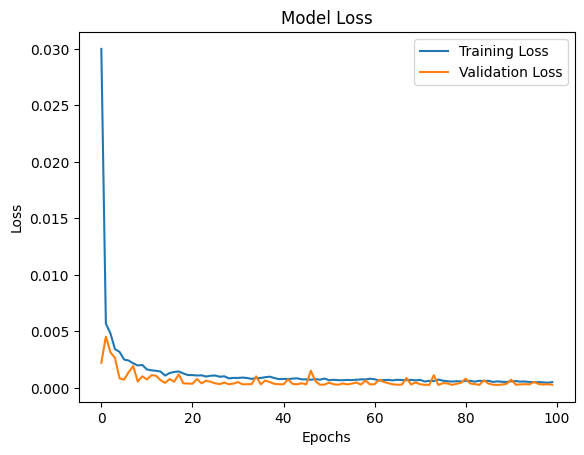

In [ ]:
# Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
#preparing the test data
real_stock_price = test.iloc[:,1:2].values
dataset = pd.concat((train['Open'], test['Open']), axis=0)
inputs = dataset[len(dataset) - len(test) - 120:].values
inputs = inputs.reshape(-1, 1)
inputs = minmaxsc.transform(inputs)
x_test = []
for i in range(120, 140):
    x_test.append(inputs[i-120:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#Predicting on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = minmaxsc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 131ms/step


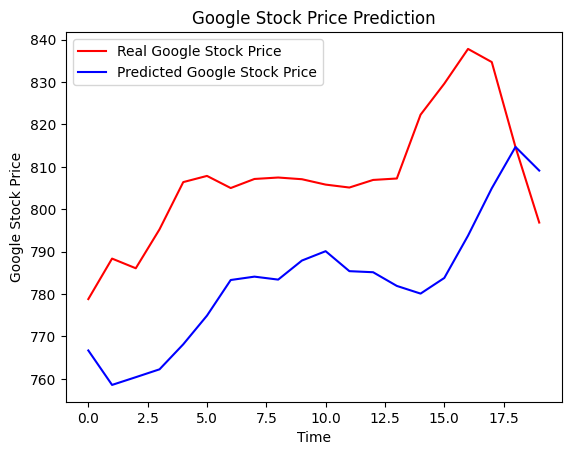

In [ ]:
# Plotting the results
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
# Calculating MSE and RMSE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 794.5125464618518
Root Mean Squared Error (RMSE): 28.187098936603103


In [ ]:
#Calculating R² Score
r2 = r2_score(real_stock_price, predicted_stock_price)
print("R² Score:", r2)

R² Score: -2.655626259816592


In [ ]:
#CalculatingMAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 25.823072265624994


# GRU

In [ ]:
results = []

# Hyperparameter tuning
units_list = [64, 128]
learning_rate_list = [0.01, 0.001]
dropout_list = [0.1, 0.2]
batch_size = 32

for units in units_list:
    for learning_rate in learning_rate_list:
        for dropout in dropout_list:
            print(f"Training with units={units}, learning_rate={learning_rate}, dropout={dropout}")

            # Building the model
            model = Sequential()
            model.add(GRU(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
            model.add(Dropout(dropout))
            model.add(GRU(units=units, return_sequences=True))
            model.add(Dropout(dropout))
            model.add(GRU(units=units, return_sequences=True))
            model.add(Dropout(dropout))
            model.add(GRU(units=units))
            model.add(Dropout(dropout))
            model.add(Dense(units=1))

            # Compiling the model
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mse')

            history = model.fit(x_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)

            #Calculating validation loss
            val_loss = history.history['val_loss'][-1]
            print(f"Validation Loss: {val_loss}")

            results.append({
                'units': units,
                'learning_rate': learning_rate,
                'dropout': dropout,
                'val_loss': val_loss
            })

results_df = pd.DataFrame(results)

# Printing the best hyperparameter combinations
best_config = results_df.sort_values(by='val_loss', ascending=True).iloc[0]
print("Best Hyperparameters:")
print(best_config)

Training with units=64, learning_rate=0.01, dropout=0.1
Epoch 1/20
29/29 [==============================] - 14s 243ms/step - loss: 0.0386 - val_loss: 0.0013
Epoch 2/20
29/29 [==============================] - 7s 225ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 3/20
29/29 [==============================] - 5s 182ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/20
29/29 [==============================] - 6s 212ms/step - loss: 0.0015 - val_loss: 5.3210e-04
Epoch 5/20
29/29 [==============================] - 6s 196ms/step - loss: 0.0016 - val_loss: 5.5416e-04
Epoch 6/20
29/29 [==============================] - 6s 208ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 7/20
29/29 [==============================] - 6s 193ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/20
29/29 [==============================] - 5s 184ms/step - loss: 0.0013 - val_loss: 4.1330e-04
Epoch 9/20
29/29 [==============================] - 5s 185ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/20
29/29 [============

In [ ]:
# Building the final model
final_model = Sequential()
final_model.add(GRU(units=int(best_config['units']), return_sequences=True, input_shape=(x_train.shape[1], 1)))
final_model.add(Dropout(best_config['dropout']))
final_model.add(GRU(units=int(best_config['units']), return_sequences=True))
final_model.add(Dropout(best_config['dropout']))
final_model.add(GRU(units=int(best_config['units']), return_sequences=True))
final_model.add(Dropout(best_config['dropout']))
final_model.add(GRU(units=int(best_config['units'])))
final_model.add(Dropout(best_config['dropout']))
final_model.add(Dense(units=1))

# Compiling the final model
final_model.compile(optimizer=Adam(learning_rate=best_config['learning_rate']), loss='mse')
history = final_model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/100
29/29 [==============================] - 13s 244ms/step - loss: 0.0559 - val_loss: 0.0161
Epoch 2/100
29/29 [==============================] - 5s 158ms/step - loss: 0.0057 - val_loss: 0.0107
Epoch 3/100
29/29 [==============================] - 5s 178ms/step - loss: 0.0020 - val_loss: 9.6148e-04
Epoch 4/100
29/29 [==============================] - 5s 184ms/step - loss: 0.0017 - val_loss: 7.4975e-04
Epoch 5/100
29/29 [==============================] - 5s 173ms/step - loss: 0.0013 - val_loss: 7.4280e-04
Epoch 6/100
29/29 [==============================] - 5s 184ms/step - loss: 0.0014 - val_loss: 4.8817e-04
Epoch 7/100
29/29 [==============================] - 5s 166ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/100
29/29 [==============================] - 5s 170ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/100
29/29 [==============================] - 5s 158ms/step - loss: 0.0013 - val_loss: 3.6756e-04
Epoch 10/100
29/29 [==============================] - 4s 152ms/step - 

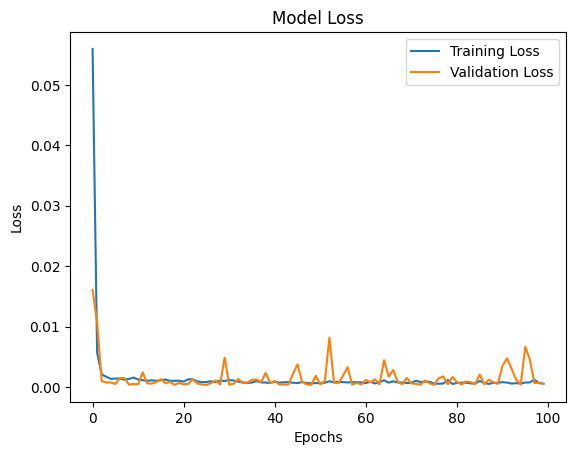

In [ ]:
# Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
#Predicting on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = minmaxsc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 84ms/step


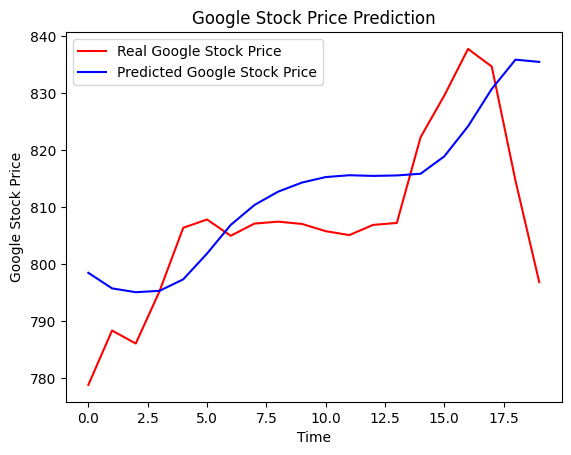

In [ ]:
# Plotting the results
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
# Calculating MSE and RMSE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 169.15061456193212
Root Mean Squared Error (RMSE): 13.00579157767539


In [ ]:
# Calculating R² Score
r2 = r2_score(real_stock_price, predicted_stock_price)

print("R² Score:", r2)

R² Score: 0.2217222607618019


In [ ]:
#Calculating MAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 10.019848388671875
